## 航空宇宙情報システム学第二

<h1><center> 第8回 主成分分析 </center> </h1>

<center>

2023年5月30日

担当教員: 矢入健久

e-mail: yairi@g.ecc.u-tokyo.ac.jp
</center>

# はじめに

前回まで3週にわたって、回帰と分類といういわゆる**教師あり学習**(supervised learning)の基礎的な手法を取り上げました。
今回と次回は、**教師なし学習**(unsupervised learning)の代表として、主成分分析と、$k$-平均法によるクラスタリングを見ていこうと思います。

今日取り上げる**主成分分析**(principal components analysis; PCA)は、様々な教師なし学習のうちで最も基本的な手法と言える存在で、次元削減、（高次元データの）可視化、データ圧縮、特徴量抽出、など、様々な用途で使われています。
昨年まで、<font color="red">航空宇宙工学科の授業で主成分分析を教えたことは無かった</font>のですが、ビッグデータ時代の今日では高次元データを扱うことが珍しくないので、今年からトピックに入れてみました。
実は、３次元のデータに対して<font color="blue">主成分を求めることは、重量分布が与えられている剛体の慣性主軸を求めることとほぼ等価</font>です。これについても後で触れようと思います。

# 最初の例題: 2次元データ

本来、主成分分析（や他の次元削減方法）の威力は、高次元データに対してこそ有難みがあるのですが、高次元のデータはそもそもイメージが難しいという問題があるので、まずは分かりやすい2次元、すなわち2変数のデータの例題から始めたいと思います。
なお、回帰や分類などの教師あり学習とは異なり、主成分分析やクラスタリングなどの<font color="red">教師なし学習では、説明変数と目標変数の区別はありません。</font>強いて言えば、全ての変数が説明変数ですが、通常は単に変数あるいは次元などと呼びます。

今、次のような2変数の$N=10$個の点（サンプル）$\boldsymbol{X}=\left[\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1} \right]^\top$から成るデータがあるとします。

| $x_0$ | $x_1$ |
|:----:|:----:|
|4.60|3.00|
|1.31|0.07|
|5.66|4.23|
|-5.24|-3.30|
|-3.10|-2.78|
|7.59|5.43|
|-0.07|0.12|
|-0.32|-0.88|
|-8.55|-4.96|
|-1.88|-0.93|

散布図は次のようになります。



array([[1.        , 0.98679829],
       [0.98679829, 1.        ]])

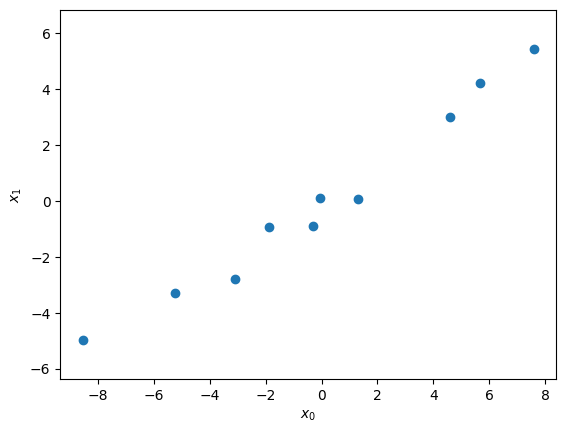

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X =np.array([[ 4.6, 3.0 ],
 [ 1.31, 0.07],
 [ 5.66, 4.23],
 [-5.24,-3.3 ],
 [-3.1, -2.78],
 [ 7.59, 5.43],
 [-0.07, 0.12],
 [-0.32,-0.88],
 [-8.55,-4.96],
 [-1.88,-0.93]])

plt.scatter(X[:,0],X[:,1])
plt.axis("equal")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")

# 相関係数(np.corrcoefはXを転置する必要がある)
np.corrcoef(X.T)

このデータは2変数$x_0$と$x_1$によって表現される2次元のデータですが、見てわかるように<font color="red">ほぼ一直線上に乗っており、実質的にほぼ1次元</font>であることが分かります。これは、2変数の相関係数が約$0.987$と極めて高いことからも分かります。

この2次元のデータに対して**主成分分析で行いたいこと**は、
1. その<font color="blue">「実質的な1次元」の(単位)方向ベクトル$\boldsymbol{v}$を見つける</font>。
2. その「実質的な1次元」を新たな座標軸にしたとき、<font color="blue">各点のその座標軸上での座標$u_0,u_1,\ldots,u_{N-1}$を求める</font>。

です。なお、説明を簡単にするために、<font color="red">このデータは作為的に全データの平均（重心）が原点$\boldsymbol{0}$に一致するように加工</font>してあります。一般にはデータの平均は原点に一致しないので、後述するように、中心化という処理が必要になります。あと、変数の下付きの添字がサンプルを表すのか、次元（変数）を表すのか分かりにくいかもしれません、、がご容赦ください。


In [ ]:
# すべての点の平均（重心）があらかじめ原点(0,0)になるようにしてある
np.mean(X,axis=0)

array([-8.88178420e-17,  5.55111512e-17])

## 共分散行列(Covariance matrix)

主成分分析の要（かなめ）は、**共分散行列**とその**対角化**にあると言えます。
また、共分散行列は、多変量の正規分布(ガウス分布)、状態空間モデルとカルマンフィルターなどでも極めて重要な役割を持ちます。
まずは、分散と共分散について整理しておきます。

### 確率変数の分散
スカラー(確率)変数$x$の分散(Variance)は、
$$
Var(x) = E[(x-E[x])^2]
$$
で定義されています。ただし、<font color="blue">$E[x]$は$x$に関する期待値、すなわち平均</font>です。具体的にデータ（サンプル集合）として、$x_0,x_1,\ldots,x_{N-1}$が与えられているときの分散(**注**)は、
$$
Var(x) = \frac{1}{N}\sum_{i=0}^{N-1} (x_i - \bar{x})^2
$$
で計算されます。ここで、$\bar{x}$は$x_i$ ($i=0,1,\ldots,N-1$)の平均です。すなわち、
$$
\bar{x} = \frac{1}{N} \sum_{i=0}^{N-1} x_i
$$
です。

**(注)** 厳密には、標本分散(sample variance)と呼びます。また、本来は、$N$ではなく$N-1$で割った**不偏分散**と区別する必要があるのですが、ここでは、気にしないことにします。

**(練習)** 上の2次元のデータについて、2つの変数それぞれの分散を求めてください。





In [ ]:
print(np.mean((X[:,0]-np.mean(X[:,0]))**2))
np.mean(X[:,1]**2)-np.mean(X[:,1])**2

22.633160000000004


10.12564

### 2変数の共分散

2つの(確率)変数$x$と$y$の共分散(Covariance)は、
$$
Cov(x,y) = E[(x-E[x])(y-E[y])]
$$
で定義されます。定義から明らかなように、**自分自身との共分散は**その変数の分散に一致します。すなわち、
$$
Cov(x,x) = Var(x)
$$
また、変数間の<font color="blue">相関係数(correlation coefficient)との関係</font>は、
$$
r_{xy} = \frac{Cov(x,y)}{\sqrt{Var(x) \cdot Var(y)}}
$$
となっています。このことからも分かるように、共分散の直感的な意味は、<font color="blue"> 2変数間の結びつきの強さ </font>です。<font color="blue">共分散はベクトル同士の内積とアナロジーが成り立ちます。</font> ということは、前述の分散$Var(x)$はベクトルの二乗ノルムに相当します。

共分散をデータから求める場合(分散のときと同様、厳密には「標本共分散」と呼びます)は、
$$
Cov(x,y) = \frac{1}{N} \sum_{i=0}^{N-1} (x_i - \bar{x})(y_i - \bar{y})
$$
です。

**(練習)** 上のデータで、2つの変数の共分散を求めてください。

In [ ]:
#np.mean(X[:,0]*X[:,1])
np.dot(X[:,0],X[:,1]) / len(X)

14.93868

### ベクトル変数(多変数)の共分散行列

スカラー変数の分散、共分散を、ベクトル変数に拡張したのが、共分散行列(covariance matrix)です。$D$次元のベクトル変数$\boldsymbol{x} \in R^D$ (**列ベクトル**で考えます) の共分散行列は、
$$
Cov(\boldsymbol{x}) =
E[(\boldsymbol{x}-\bar{\boldsymbol{x}}) (\boldsymbol{x}-\bar{\boldsymbol{x}})^\top] = \left[
\begin{matrix}
Var(x_0) & Cov(x_0,x_1) &\cdots & Cov(x_0,x_{D-1}) \\
Cov(x_1,x_0) & Var(x_1) &\cdots & Cov(x_1,x_{D-1}) \\
\vdots & \vdots & \ddots & \vdots \\
Cov(x_{D-1},x_0) & Cov(x_{D-1},x_1) & \cdots & Var(x_{D-1})
\end{matrix}
\right]
$$

共分散行列は色々と興味深い性質を持っているのですが、今回は時間が無いので割愛します。気になる人は[Wikipediaの解説](https://ja.wikipedia.org/wiki/%E5%88%86%E6%95%A3%E5%85%B1%E5%88%86%E6%95%A3%E8%A1%8C%E5%88%97)などを読んでください。

データ行列$\boldsymbol{X}=\left[\boldsymbol{x}_0, \boldsymbol{x}_1, \ldots, \boldsymbol{x}_{N-1} \right]^\top$から共分散行列を求める場合、上の定義式に従って各成分を求めても良いのですが、Numpy等で計算する場合には、以下の2つの方法のいずれかを使うと便利です。

**(方法1)** データ行列を中心化してから求める方法
1. まず、平均ベクトル$\bar{\boldsymbol{x}}$を求める。
2. $\boldsymbol{X}$の各行から$\bar{\boldsymbol{x}}$を引いた行列$\tilde{\boldsymbol{X}}=\left[\boldsymbol{x}_0-\bar{\boldsymbol{x}}, \boldsymbol{x}_1-\bar{\boldsymbol{x}}, \ldots, \boldsymbol{x}_{N-1}-\bar{\boldsymbol{x}} \right]^\top$ を作る。
3. 共分散行列$\boldsymbol{C}$は以下で計算できる。
$$
\boldsymbol{C}=\frac{1}{N} \tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}}
$$

**(方法2)** 中心化しないで求める方法
$$
\boldsymbol{C} = \frac{1}{N} \boldsymbol{X}^\top \boldsymbol{X} - \bar{\boldsymbol{x}} \bar{\boldsymbol{x}}^\top
$$

主成分分析を行う場合は、主成分得点(後述)を求める際に、中心化されたデータ行列$\tilde{\boldsymbol{X}}$を使うので、**(方法1)**がお薦めです。

それぞれの方法で例題のデータの共分散行列を求めると次のようになります。<font color="red"> ただし、今回はあらかじめ$\boldsymbol{x}_i$の平均が$\boldsymbol{0}$になるように中心化しているので、いきなり、$\boldsymbol{C} = \frac{1}{N} \boldsymbol{X}^\top \boldsymbol{X}$ </font> を求めても同じ結果になります。

In [ ]:
n = len(X)
# 方法1
Xc = X - np.mean(X,axis=0)
C1 = (1/n) * np.dot(Xc.T,Xc)
print("C1=\n",C1)
# 方法2
mn = np.mean(X,axis=0)
C2 = (1/n) * np.dot(X.T,X) - np.outer(mn,mn)
print("C2=\n",C2)
# 今回はあらかじめXは中心化されているので、以下でOK
C = (1/n) * np.dot(X.T,X)
print("C=\n",C)

C1=
 [[22.63316 14.93868]
 [14.93868 10.12564]]
C2=
 [[22.63316 14.93868]
 [14.93868 10.12564]]
C=
 [[22.63316 14.93868]
 [14.93868 10.12564]]


## 単位方向ベクトルに射影したデータの分散

今求めたい「実質的な1次元」というのは、言い換えれば<font color="blue">元のデータ $\boldsymbol{X}$
が持っている情報（データの広がり=分散）をできるだけ多く保存する方向</font>ということです。

一方、$i$番目の点$\boldsymbol{x}_i$を、原点を通り単位方向ベクトル$\boldsymbol{v}$に平行な軸に射影したときの座標$u_i$は、$\boldsymbol{v}$と$\boldsymbol{x}_i$との内積になります。すなわち、
$$
u_i = \boldsymbol{v} \cdot \boldsymbol{x}_i = \boldsymbol{v}^\top  \boldsymbol{x}_i
$$
ですから、$u_i$ ($i=0,1,\ldots,N-1$) の分散は、
$$
Var(u) = \frac{1}{N} \sum_{i=1}^{N-1} (u_i-\bar{u})^2
$$
です。ここで、$\bar{u}$は$u_i$ ($i=0,1,\ldots,N-1$)の平均ですが、先程、全データの平均$\bar{\boldsymbol{x}}$が$\boldsymbol{0}$と仮定しているので、
$$
\bar{u} = \frac{1}{N} \sum_{i=0}^{N-1} u_i = \frac{1}{N} \sum_{i=0}^{N-1} \boldsymbol{v} \cdot \boldsymbol{x}_i
= \boldsymbol{v} \cdot \left( \frac{1}{N} \sum_{i=0}^{N-1}  \cdot \boldsymbol{x}_i \right) = \boldsymbol{v} \cdot \bar{\boldsymbol{x}} = 0
$$
です。したがって、$u$の分散は、
$$
Var(u) = \frac{1}{N} \sum_{i=0}^{N-1} u_i^2 = \frac{1}{N} \sum_{i=0}^{N-1} \left( \boldsymbol{v} \cdot \boldsymbol{x}_i \right)^2
= \frac{1}{N} \sum_{i=0}^{N-1} \boldsymbol{v}^\top \boldsymbol{x}_i \boldsymbol{x}_i^\top \boldsymbol{v}
= \boldsymbol{v}^\top \left( \frac{1}{N} \boldsymbol{X}^\top \boldsymbol{X} \right) \boldsymbol{v}
= \boldsymbol{v}^\top \boldsymbol{C} \boldsymbol{v}
$$
のように二次形式で書けます。ここでも、$\bar{\boldsymbol{x}}=\boldsymbol{0}$であることを使用しました。


**(練習)** $\boldsymbol{x}_i$ ($i=0,1,\ldots,9$)を単位方向ベクトル $\boldsymbol{v}=\left[0.6, 0.8 \right]^\top$ に射影したときの分散を求めてください。


In [ ]:
v = np.array([0.6,0.8])
np.dot(v,np.dot(C,v))

28.969480000000004

## 分散が最大となる単位方向ベクトル

上で導出したように、単位方向ベクトル$\boldsymbol{v}$に射影した各点の座標を$u_i$としたとき、$u$の分散は、
$$
Var(u)=\boldsymbol{v}^\top \boldsymbol{C} \boldsymbol{v}
$$
であることがわかりました。そこで、<font color="red">この分散が最大になるような単位方向ベクトル</font>を求めます。これは、次のような<font color="red">制約条件付き最大化問題</font>として書くことができます。

$$
\begin{align}
\mbox{maximize} &\hspace{3mm} \boldsymbol{v}^\top \boldsymbol{C} \boldsymbol{v} \\
\mbox{subject to} &\hspace{3mm} \boldsymbol{v}^\top \boldsymbol{v} = 1
\end{align}
$$

これを、<font color="red">ラグランジュの未定乗数法</font>を使って解きます。未定乗数を$\lambda$として以下のラグランジュ関数を定義します。
$$
L(\boldsymbol{v},\lambda) = \boldsymbol{v}^\top \boldsymbol{C} \boldsymbol{v} + \lambda \left(1 - \boldsymbol{v}^\top \boldsymbol{v} \right)
$$
鞍点定理により、最適性条件は、
$$
\frac{\partial L(\boldsymbol{v},\lambda)}{\partial \boldsymbol{v}} = 2 \left(\boldsymbol{C} \boldsymbol{v} - \lambda \boldsymbol{v} \right) = \boldsymbol{0}
$$
となります。すなわち、
$$
\boldsymbol{C} \boldsymbol{v} = \lambda \boldsymbol{v}
$$
であり、<font color="blue"> 求めたいベクトル$\boldsymbol{v}$は、共分散行列$\boldsymbol{C}$の固有ベクトル</font>だということです。そして、<font color="red">このベクトルにデータを射影したときの分散は、</font>
$$
Var(u) = \boldsymbol{v}^\top \boldsymbol{C} \boldsymbol{v} = \lambda \boldsymbol{v}^\top \boldsymbol{v} = \lambda
$$
となり、<font color="red">共分散行列$\boldsymbol{C}$の2つの固有値のうちのいずれか</font>に等しいことが分かりますが、
<font color="blue">分散を最大化したいので、大きい方の固有値が求めたい値</font>だと分かります。

以上をまとめると、

「データ$\boldsymbol{X}$を射影したときに分散が最大になるような単位方向ベクトルは、共分散行列$\boldsymbol{C}$の最大固有値$\lambda_0$に対応する固有ベクトル$\boldsymbol{v}_0$であり、その時の分散は最大固有値$\lambda_0$である。」

ということになります。そして、<font color="blue">分散を最大化する方向を第1主成分(the 1st principal component)と呼びます</font>。

それでは、共分散行列$\boldsymbol{C}$の固有値、固有ベクトルを実際にNumPyで求めてみましょう。このとき、<font color="blue">一般の非対称正方行列にも適用できる`eig()`関数よりも、対称行列に特化した`eigh()`関数を使う方が良い</font>です。

In [ ]:
import numpy.linalg as la
lmd,V = la.eigh(C)
print("eigenvalues:",lmd)
print("eigenvectors:\n", V)

eigenvalues: [ 0.18453432 32.57426568]
eigenvectors:
 [[ 0.55400498 -0.83251335]
 [-0.83251335 -0.55400498]]


<font color="red">`eigh()`関数は、固有値を昇順(小さい順)で返します。 また、各固有値に対応する固有ベクトルを列ベクトルとして並べた行列を返します。</font> また、固有ベクトルは単位ベクトルになっています。

従って、この場合、第１主成分に対応する単位方向ベクトル$\boldsymbol{v}_0$、それに射影したデータの座標(主成分得点と呼ばれます)、そしてその分散は、以下のように求まります。

In [ ]:
# 第１主成分の単位方向ベクトル
print("1st PC direction:", V[:,1])
# 10個の点を射影した座標（第１主成分得点）
u = np.dot(X,V[:,1])
print("1st PC score:\n",u)
# 第１主成分得点の分散 = 最大固有値
print("Largest eigenvalue:",lmd[1])
# uの分散と一致するか一応確認
varu = np.mean(u**2)-np.mean(u)**2
print("Variance of u:",varu)


1st PC direction: [-0.83251335 -0.55400498]
1st PC score:
 [-5.49157636e+00 -1.12937284e+00 -7.05546664e+00  6.19058640e+00
  4.12092524e+00 -9.32702339e+00 -8.20466370e-03  7.53928658e-01
  9.86585386e+00  2.08034973e+00]
Largest eigenvalue: 32.57426567650378
Variance of u: 32.57426567650378


ここの注目ポイントは、元々、２つの変数 $x_0$, $x_1$に関する分散は、それぞれ、$22.63$, $10.13$でその和は$32.76$でした。それに対して、新しい変数$u$に関する分散は$32.57$あり、元の2変数の分散の総和をほぼ保っているということです。

一般に、共分散行列の$i$番目に大きな固有値に対応する固有ベクトルの方向を第
$i$主成分と呼びます。今扱っている例題では、2つしか固有値が無いので必然的にもう1つの固有値、固有ベクトルが第2主成分ということになります。

共分散行列$\boldsymbol{C}$は実対称行列なので、<font color="red">異なる固有ベクトルは互いに直交</font>します。また、$\boldsymbol{C}$は単に対称なだけでなく、半正定(semi-positive definite)であり、<font color="blue">全ての固有値が0以上</font>です。
このことは、データをどんな方向に写像してみても、分散が0より小さくなり得ないことと整合しています。

元のデータの散布図に、第１主成分、第２主成分の方向を表示してみると、

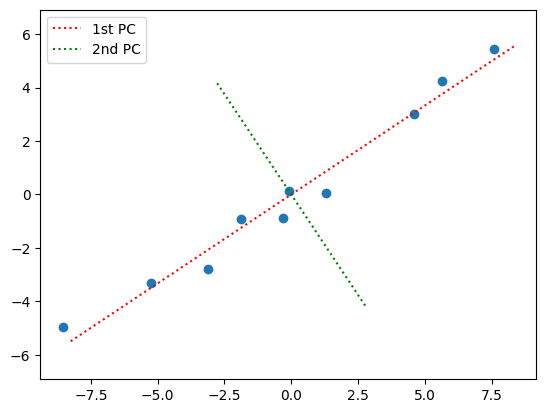

In [ ]:
plt.scatter(X[:,0],X[:,1])
plt.axis("equal")
ln0 = np.outer(np.array([-10,10]),V[:,1])
plt.plot(ln0[:,0],ln0[:,1],"r:",label="1st PC")
ln1 = np.outer(np.array([-5,5]),V[:,0])
plt.plot(ln1[:,0],ln1[:,1],"g:",label="2nd PC")
plt.legend()

結局、主成分分析とは、
1. データの共分散行列を求める。
1. 共分散行列の固有値、固有ベクトルを求める。
1. 最大の固有値、それに対応する固有ベクトルから順番に、第1, 第2, ... 第$D$主成分とする。

ということです。別の見方をすると、<font color="blue">主成分分析は共分散行列が対角化されるようにデータを正規直交変換している</font>という解釈も可能です。

固有値を大きい順に並べたものを対角成分に持つ対角行列を$\boldsymbol{\Lambda}$とし、対応する固有ベクトルを並べた行列を$\boldsymbol{V}$とすると、
$$
\boldsymbol{V}^\top \boldsymbol{C} \boldsymbol{V} = \boldsymbol{\Lambda}
$$
が成り立ちますが、もともと、共分散行列が中心化されたデータ行列$\tilde{\boldsymbol{X}}$を使って、
$$
\boldsymbol{C} = \frac{1}{N} \tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}}
$$
であったことを利用すると、
$$
\boldsymbol{V}^\top \boldsymbol{C} \boldsymbol{V}
=  \frac{1}{N} \boldsymbol{V}^\top\tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}} \boldsymbol{V}
=  \frac{1}{N} \boldsymbol{U}^\top \boldsymbol{U}
= \boldsymbol{\Lambda}
$$

ここで、$\boldsymbol{U}=[\boldsymbol{u}_0,\boldsymbol{u}_1,\ldots,\boldsymbol{u}_{N-1}]$は、正規直交変換されたデータの座標を並べた行列です。すなわち、固有値の対角行列$\boldsymbol{\Lambda}$は新しい座標系でのデータの共分散行列を表しているということになり、対角行列（非対角成分が全て$0$）ということは変換された座標系では、各変数間の共分散が0ということになります。

**(練習)** 上の式が成り立っているかどうか例題の場合について確かめてください。


# 剛体の慣性主軸との関係

ある剛体の質量分布が$N$個の単位質点で表現されるとし、各質点の3次元座標が$(x_i,y_i,z_i)$ ($i=0,1,2,\ldots,N-1$) だとします。ただし、議論を易しくするため、<font color="blue">重心が原点に一致する</font>と仮定します。このとき、慣性テンソル$\boldsymbol{J}$は、
$$
\boldsymbol{J} =
\left[
\begin{matrix}
\sum (y_i^2+z_i^2) & -\sum y_i x_i & -\sum z_i x_i \\
-\sum x_i y_i & \sum (z_i^2+x_i^2) & -\sum z_i y_i \\
-\sum x_i z_i & -\sum y_i z_i & \sum (x_i^2+y_i^2)
\end{matrix}
\right]
$$
で求まります。
**(注意)** 単位行列と区別するために、$\boldsymbol{I}$ではなく$\boldsymbol{J}$という記号を使っています。

このとき、<font color="blue">慣性主軸は、慣性テンソル$\boldsymbol{J}$の固有ベクトル</font>として求まりますが、これは、<font color="red">質点の座標集合を3次元(3変数)のデータとして見たときの主成分と一致</font>します。

なぜなら、慣性テンソル$\boldsymbol{J}$と、共分散行列$\boldsymbol{C}$との間に、
$$
\boldsymbol{J} = N \cdot \left( Tr(\boldsymbol{C}) \cdot \boldsymbol{I} - \boldsymbol{C} \right)
$$
という関係があるからです(余裕のある人は確認してみてください。)。ここで、$Tr(\boldsymbol{C})$は、共分散行列$\boldsymbol{C}$のトレース、すなわち、対角成分の和、$\boldsymbol{I}$は単位行列です。もし、$\boldsymbol{v}$が$\boldsymbol{C}$の固有ベクトルだとすれば、それは、$\boldsymbol{J}$の固有ベクトルでもあり、その逆も成り立ちます。

余談ですが、共分散行列$\boldsymbol{C}$のトレース$Tr(\boldsymbol{C})$は、
$$
Tr(\boldsymbol{C}) = \frac{1}{N} Tr(\tilde{\boldsymbol{X}}^\top \tilde{\boldsymbol{X}}) = \frac{1}{N} \sum_{i=0}^{N-1} \sum_{j=0}^2 \tilde{x}_{i,j}^2
$$
すなわち、中心化されたデータ行列の全要素の二乗和をデータサンプル数$N$で割ったものに一致します。




## Stanford Bunny の慣性主軸・主成分を求めてみる

何か良い3次元の点群データが無いか探してみたら、[こういうページ](https://data.nrel.gov/submissions/153)があって、その中の [bunny.csv](https://data.nrel.gov/system/files/153/bunny.csv)がお手軽そうだったので、これを使ってみます。

Pandas の`read_csv()`関数でデータフレームに読み込んでも良いのですが、元ファイルのCSVを見てみると、ヘッダーも無いシンプルなファイルなので、今回はNumpyの`loadtxt()`関数でarray型に読み込んでみます。


In [ ]:
# うさぎの3D点群を読み込む
Xbun = np.loadtxt('/content/drive/My Drive/bunny.csv',delimiter=',')
# (重心が原点に一致するように)中心化を行う
xgc = np.mean(Xbun,axis=0)
print("Original GC:",xgc)
Xbun = Xbun - xgc
# 点(サンプル)の数
npt = len(Xbun)
print("Number of points:",npt)

Original GC: [0.00535993 0.00118217 0.00047797]
Number of points: 992


Matplotlib で散布図を描いてみます。粗い点群なので、視点を調節しないと、ウサギに見えないのが難点です。。

あと、このデータは3Dスキャナーで計測したデータが元になっているらしく、ウサギモデルの表面上の点の集合になっている、つまり、中は空洞という前提ということに注意が必要です。

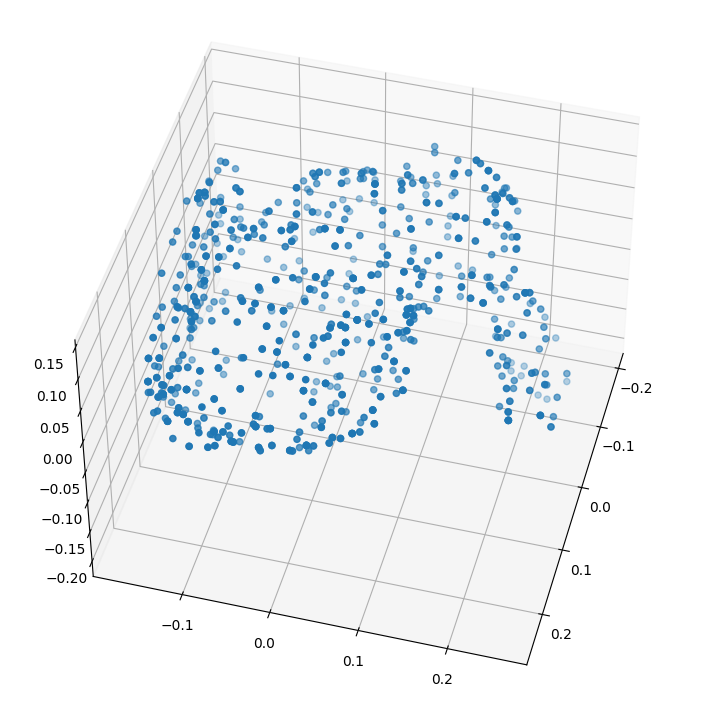

In [ ]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')
ax.scatter(Xbun[:,0],Xbun[:,1],Xbun[:,2])
#plt.show()
ax.view_init(elev=45,azim=15)

各点が単位質量を持つものとして慣性テンソルを求めてみましょう。定義に従って求めると、こんな感じでしょうか。

In [ ]:
# x^2+y^2+z^2 の総和
sqsum = np.sum(Xbun**2)
Jbun = np.zeros((3,3))
for j in range(3):
  for k in range(j,3):
    if j==k:
      Jbun[j,k] = sqsum - np.sum(Xbun[:,j]**2)
    else:
      Jbun[j,k] = Jbun[k,j] = -np.dot(Xbun[:,j],Xbun[:,k])
print("Inertia tensor: \n",Jbun)



Inertia tensor: 
 [[19.94132725  5.14455439 -0.2123321 ]
 [ 5.14455439 19.50892138  1.09434255]
 [-0.2123321   1.09434255 27.62375671]]


一方、共分散行列を求めてみると、

In [ ]:
Cbun = 1/npt * np.dot(Xbun.T,Xbun)
print("Covariance matrix:\n",Cbun)

Covariance matrix:
 [[ 0.01370532 -0.00518604  0.00021404]
 [-0.00518604  0.01414121 -0.00110317]
 [ 0.00021404 -0.00110317  0.00596093]]


両者の関係式
$$
\boldsymbol{J} = N \cdot \left( Tr(\boldsymbol{C}) \cdot \boldsymbol{I} - \boldsymbol{C} \right)
$$
が成り立っているか確かめるために、右辺を計算してみます。

In [ ]:
Jbun2 = npt*(np.trace(Cbun)*np.eye(3)-Cbun)
print("Inertia tensor 2:\n",Jbun2)

Inertia tensor 2:
 [[19.94132725  5.14455439 -0.2123321 ]
 [ 5.14455439 19.50892138  1.09434255]
 [-0.2123321   1.09434255 27.62375671]]


一致していました。次に、慣性テンソル、共分散行列それぞれの固有値、固有ベクトルを計算してみます。

In [ ]:
# Eigendecomposition of inertia tensor
lmdj,Vj = la.eigh(Jbun)
print("Eigenvalues of intertia tensor:",lmdj)
print("Eigenvectors of inertia tensor:\n",Vj)

# Eigendecomposition of covariance matrix
lmdc,Vc = la.eigh(Cbun)
print("Eigenvalues of covariance matrix:",lmdc)
print("Eigenvectors of covariance matrix:\n",Vc)

Eigenvalues of intertia tensor: [14.50892525 24.75087967 27.81420043]
Eigenvectors of inertia tensor:
 [[ 0.68732225  0.71983625 -0.0970768 ]
 [-0.72283055  0.6647075  -0.18889132]
 [ 0.07144314 -0.19999929 -0.97718788]]
Eigenvalues of covariance matrix: [0.00576895 0.00885698 0.01918153]
Eigenvectors of covariance matrix:
 [[ 0.0970768   0.71983625 -0.68732225]
 [ 0.18889132  0.6647075   0.72283055]
 [ 0.97718788 -0.19999929 -0.07144314]]


固有値の大小が逆転していますが、慣性テンソル$\boldsymbol{J}$と共分散行列$\boldsymbol{C}$ それぞれの<font color="blue">3つの固有ベクトルは（向きの違いはありますが）一致</font>しています。

前の例題で説明したように、第１主成分はデータの分散を最も大きくする方向です。また、<font color="red">第２主成分は、第１主成分に直交するという条件下で(次に)最も分散を最大化する方向</font>です。

上位2つの主成分、すなわち、
<font color="blue">第１主成分を横軸、第２主成分を縦軸にしてプロットしてみると、（少し語弊はありますが）、ウサギの形状を最も特徴的に表現する(ウサギらしさを最も表現する)平面への射影</font>が得られます。

Text(0, 0.5, 'PC 2')

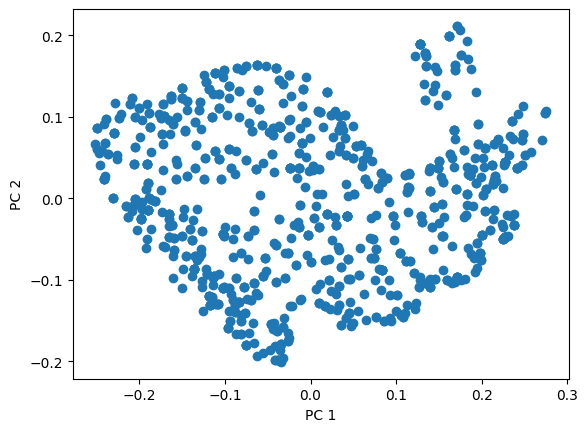

In [ ]:
Ubun = np.dot(Xbun,Vc[:,::-1])
# 第1主成分、第２主成分をプロット
plt.scatter(Ubun[:,0],Ubun[:,1])
plt.xlabel("PC 1")
plt.ylabel("PC 2")

この平面に鉛直な方向が第３主成分であるが、それが最大モーメントの慣性主軸の方向に一致します。確かに、上の図からもこの平面内での回転は安定であるように思えます。

逆に、下位2つの主成分、すなわち、
<font color="red">第３主成分、第２主成分の２次元で散布図をプロットすると、最も特徴のない（分散の小さい）平面への射影</font>になります。

Text(0, 0.5, 'PC 2')

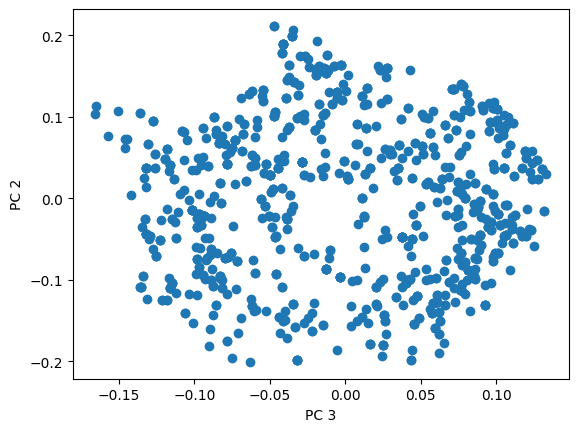

In [ ]:
# 第3主成分、第2主成分をプロット
plt.scatter(Ubun[:,2],Ubun[:,1])
plt.xlabel("PC 3")
plt.ylabel("PC 2")

確かにこの2次元散布図からは、ウサギの形を認識するのは難しいですね。

この例題から得られる知見としては、第１主成分とはデータが持っている分散(=情報)を最も多く含むような射影方向であり、第２主成分以下は（上位の主成分を除いて）次に分散(=情報)を含む射影方向である、ということです。


# さらに高次元なデータに対する主成分分析

冒頭でも述べたように、主成分分析（を始めとする次元削減、特徴抽出）の真価は、高次元なデータ、すなわち変数がたくさんあるようなデータでこそ発揮されます。そこで最後に、そのような高次元なデータを扱ってみたいと思います。

## (例題)都道府県別家計支出データ

UCI Machine Learning Repository で、主成分分析向きの面白い題材が無いか探したのですが、どれもイマイチだったので、趣向を変えて政府公開データの中から、 [「全国家計構造調査(2019年)」](https://www.e-stat.go.jp/dbview?sid=0003424735)を選んでみました。リンク先のページで、47都道府県別の平均家計支出データを1つ1つダウンロードして、それを1つの表ファイルにしました。

端的に言えば、各県の家庭が平均的に「何にどれだけ支出しているか」を示したデータです。



In [ ]:
import pandas as pd
dfpref = pd.read_csv('/content/drive/My Drive/都道府県別支出統計細目2019.csv',skiprows=1,index_col=0)
display(dfpref)

# 変数の項目
print(dfpref.columns)
print("Number of variables:",len(dfpref.columns))

,穀類,魚介類,肉類,乳卵類,野菜・海藻,果物,油脂・調味料,菓子類,調理食品,飲料,...,他の教養娯楽サービス,諸雑費,理美容サービス,理美容用品,身の回り用品,たばこ,他の諸雑費,こづかい（使途不明）,交際費,仕送り金
都道府県,,,,,,,,,,,,,,,,,,,,,
北海道,4848,5007,4453,2406,5697,2340,2602,4970,7209,3783,...,7136,17408,2534,3000,1040,1403,9431,5670,9591,5048
青森県,5197,5816,5285,2763,7027,3188,3121,4819,8439,4408,...,6171,25056,1853,2697,707,1776,18022,4484,7528,5588
岩手県,5587,6453,4720,3090,6965,3197,3086,5746,8322,4269,...,6784,20054,2585,3872,957,1849,10790,4898,9480,6263
宮城県,6390,5314,5292,3146,6968,2772,2959,5575,9562,4153,...,8028,20932,2587,3027,1390,1127,12801,4088,9049,4905
秋田県,6113,6225,5549,2872,7328,3086,3224,5160,8998,4089,...,6531,17849,2138,2887,778,937,11111,5706,9714,8628
山形県,7183,5870,6548,3207,8161,3987,3610,5824,10456,4050,...,7650,21433,2405,2992,1236,1229,13571,5784,11018,8924
福島県,6753,5354,5319,2944,7313,3372,3106,5219,9537,4149,...,6851,24492,2313,3007,961,1159,17054,7273,12402,5815
茨城県,4889,4755,5131,3082,6780,2577,2872,5675,10370,4990,...,9183,21595,2357,3623,1161,1442,13012,7321,9878,4896
栃木県,5226,4280,4820,2818,6779,2657,2950,5273,9617,4171,...,8976,21379,2459,3722,1463,1444,12290,7499,9532,5460


Index(['穀類', '魚介類', '肉類', '乳卵類', '野菜・海藻', '果物', '油脂・調味料', '菓子類', '調理食品', '飲料',
       '酒類', '外食', '一般外食', '学校給食', '賄い費', '家賃地代', '設備修繕・維持', '設備材料',
       '工事その他のサービス', '電気代', 'ガス代', '他の光熱', '上下水道料', '家庭用耐久財', '家事用耐久財',
       '冷暖房用器具', '一般家具', '室内装備・装飾品', '寝具類', '家事雑貨', '家事用消耗品',
       'ティッシュペーパー・トイレットペーパー', '洗剤', '他の家事用消耗品', '家事サービス', '和服', '洋服',
       'シャツ・セーター類', '下着類', '生地・糸類', '他の被服', '履物類', '被服関連サービス', '医薬品',
       '健康保持用摂取品', '保健医療用品・器具', '保健医療サービス', '交通', '自動車等関係費', '自動車等購入', '自転車購入',
       '自動車等維持', '通信', '授業料等', '教科書・学習参考教材', '補習教育', '教養娯楽用耐久財', '教養娯楽用品',
       '文房具', '運動用具類', '玩具', '切り花', '他の教養娯楽用品', '動物病院代', '他のペット関連サービス',
       '教養娯楽用品修理代', '書籍・他の印刷物', '教養娯楽サービス', '宿泊料', 'パック旅行費', '月謝類',
       '他の教養娯楽サービス', '諸雑費', '理美容サービス', '理美容用品', '身の回り用品', 'たばこ', '他の諸雑費',
       'こづかい（使途不明）', '交際費', '仕送り金'],
      dtype='object')
Number of variables: 81


各都道府県において、一世帯あたり81種類の支出項目に対して平均でいくら使ったかが記録されています。つまり、このデータは、81変数、47サンプルから構成されています。

このデータに対して主成分分析を行うことによって、<font color="blue">都道府県を特徴付けるような支出パターンが見えてくる</font>のではないか、と期待されます。

ところで、このデータは、都道府県名(行名)、支出項目名(列名)が日本語になっています。Pandasでは問題なく扱えるのですが、<font color="red">Matplotlibでは文字化けが生じてしまうので、回避策として、日本語化されたMatplotlibをインストール</font>してそれを使う、ということを行います。

In [ ]:
!pip install japanize-matplotlib
import japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d32c8795096157250832c43f3cff57263aa46318104df811ede7aea0262ded9b
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib


## 中心化と標準化

次に、データの**中心化**、すなわち各変数ごとに平均がゼロになるようにします。
前回まで取り組んだ回帰や分類の際には、説明変数の**標準化**ということを行いました。中心化との違いは、平均がゼロになるような平行移動を行うことに加えて、<font color="red">各変数の標準偏差が1になるようなスケーリングも行う</font>、という点です。
実は、<font color="red">主成分分析でも、変数を標準化してから共分散行列を求め、固有値・固有ベクトルを求める場合があります。</font> これは、共分散行列の代わりに<font color="blue">相関行列を固有値分解</font>することと等価です。

データを構成する変数間で単位やオーダーなどに大きな違いがある場合には、標準化を行うことが好ましいですが、<font color="red">今回扱う支出データの場合は、全ての変数(項目)の単位が「円」なので、スケーリングしてしまうと却って変数の意味が失われてしまいます。</font>
そこで、ここでは、中心化だけを行うことにします。

In [ ]:
# 中心化してarray型に変換
Xpref = (dfpref-dfpref.mean()).values

## 共分散行列の固有値分解と降順の並び替え

データ行列$\boldsymbol{X}$は中心化されているので、
あとは、共分散行列を、
$$
\boldsymbol{C} = \frac{1}{N} \boldsymbol{X}^\top \boldsymbol{X}
$$
で計算し、その固有値・固有ベクトルを求めて、<font color="blue">固有値の大きい順番に並び替え</font>れば、ほぼ処理は完了です。
最大固有値から大きい順番に、第1主成分、第2主成分、$\cdots$となります。

主成分の数、すなわち、固有値の数は変数の数、すなわち、このデータでは$81$個ありますが、サンプル数がそれよりも少ない$47$個なので、理論上は$81-(47-1)=35$個の固有値は厳密に$0$です。

**(注意)** これは、共分散行列$\boldsymbol{C}$の級数(rank)が最大でもデータ行列$\boldsymbol{X}$の**行数(サンプル数)-1** と **列数(変数の数)**の大きい方になるからです。

In [ ]:
# 共分散行列
Cpref = (1/len(Xpref))*np.dot(Xpref.T,Xpref)
# 共分散行列のrank
print("rank of Cpref",la.matrix_rank(Cpref))
# 固有値固有ベクトル
lmdp,Vp = la.eigh(Cpref)
# 大きい順(降順)に並び替え
lmdp = lmdp[::-1]
Vp = Vp[:,::-1]

rank of Cpref 46


## 累積寄与率

第何主成分までが重要な意味を持っているかを調べるのに、累積寄与率というものがしばしば使われます。これは、最大固有値から降順に累積和を求め、それが総分散($Trace(\boldsymbol{C}) = \sum_{i=0}^{D-1} \lambda_i$)のどれだけの割合を占めるかを示したものです。

なお、Numpy では数列の累積和を`cumsum()`関数で求めることができます。

Text(0, 0.5, 'Cumulative explained variance')

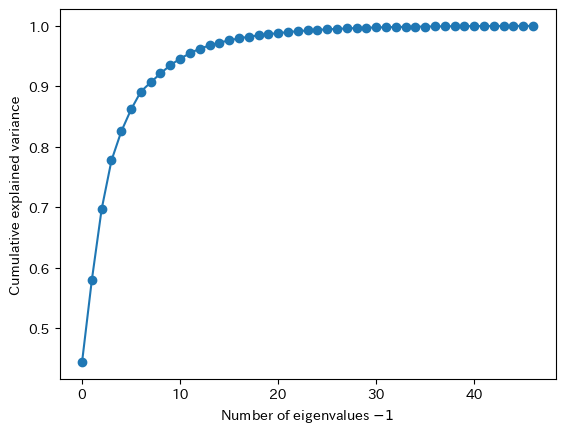

In [ ]:
totvar = np.trace(Cpref)
# 固有値の累積和をプロット
plt.plot(np.cumsum(lmdp[:len(Xpref)])/totvar,"o-")
plt.xlabel("Number of eigenvalues $-1$")
plt.ylabel("Cumulative explained variance")

累積寄与率は、<font color="blue">元の高次元データが持っている分散(=情報)を、上位いくつの主成分でどれだけ再現できるか</font>、を表しています。
明確な決まりがあるわけではありませんが、例えば累積寄与率が$0.9$を超えるところまでの上位の主成分を考察する、というようなことが行われます。

今回扱っているデータでは、上位8個の固有値・主成分の累積寄与率が、$0.907$となるので、大体、第8主成分くらいまで考えれば良いだろう、ということです。

## 主成分分析による可視化

もともと81次元のデータをそのままグラフなどにして表示するのは困難ですが、上位の主成分を新たな変数（座標）として、散布図を描いてみると、元のデータの分布を最大限保存しつつ、低次元空間(平面もしくは3次元空間)で表示することができます。

ということで、第1主成分、第２主成分を横軸、縦軸にして47都道府県をプロットしてみます。

Text(0, 0.5, 'PC 2')

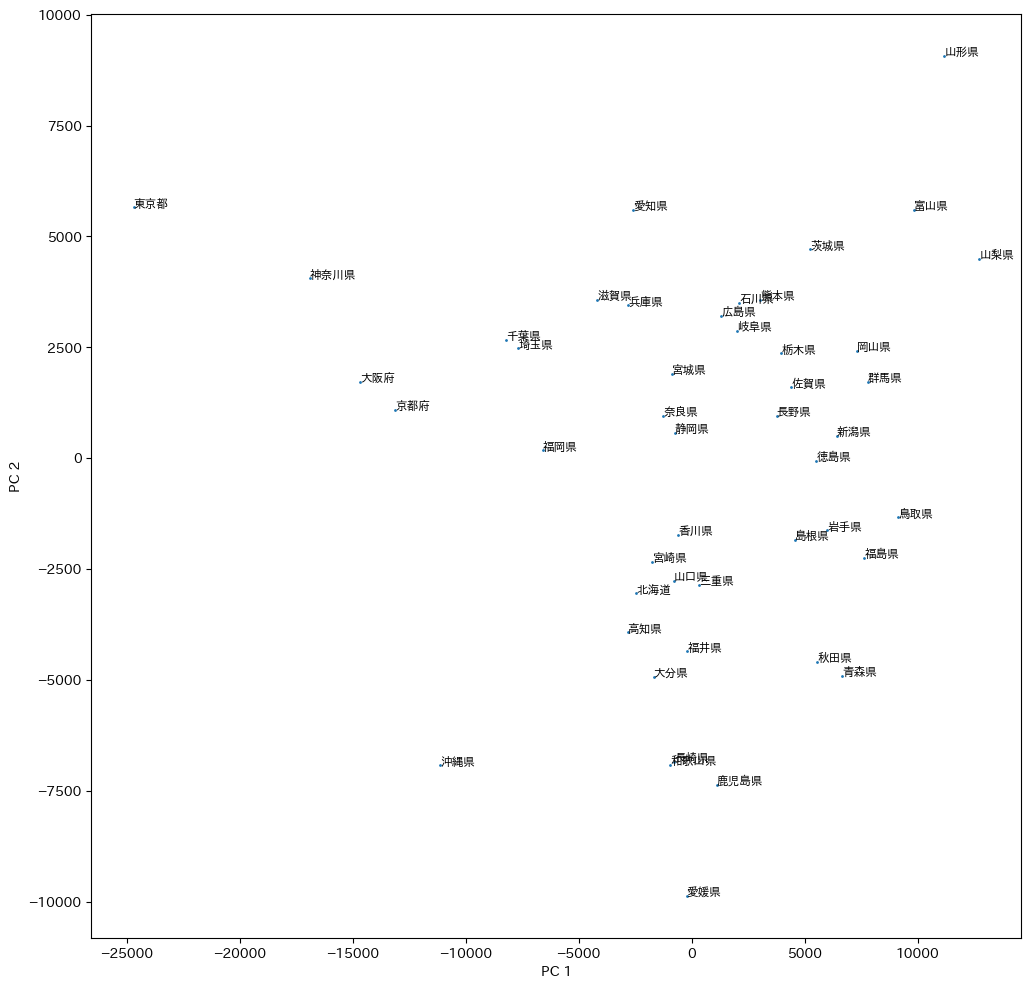

In [ ]:
# 第8主成分まで、座標（主成分得点）を求める
Up = np.dot(Xpref,Vp[:,:8])

# 第1,第2主成分を横軸、縦軸にして都道府県をプロット
plt.figure(figsize=(12, 12))
plt.scatter(Up[:,0],Up[:,1],s=1)
prefs = list(dfpref.index)
for i in range(len(prefs)):
  plt.text(Up[i,0],Up[i,1],prefs[i],fontsize="small")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

第1主成分(横軸)の左の方に、東京、神奈川、大阪、京都、と大都市圏を持つ都道府県が並ぶ中、<font color="blue">5番目に沖縄県</font>が入っています。このことからピンと来る(?)のは、借家率および公共交通の普及度合です。また、右の方には、富山、山形など持ち家率の高い県、山梨、富山、群馬、など車保有率の高そうな県が並んでいます。このことから、

第1主成分は、<font color="red">「持ち家率と自家用車保有率の高い（あるいはその逆に、借家率と公共交通依存率の高い）都道府県の指標（「不動産＋動産」保有率）になっている。」</font>のではないか、という仮説が考えられます。

一方、第2主成分はなかなか難しいですね。

## 主成分のベクトル成分

各主成分がどのような意味を持つのかは、固有ベクトルをどのような成分が占めているのかを見ることによってより詳しく分析することができます。
そこで、第2主成分の固有ベクトルの各成分を棒グラフで示してみます。

<BarContainer object of 81 artists>

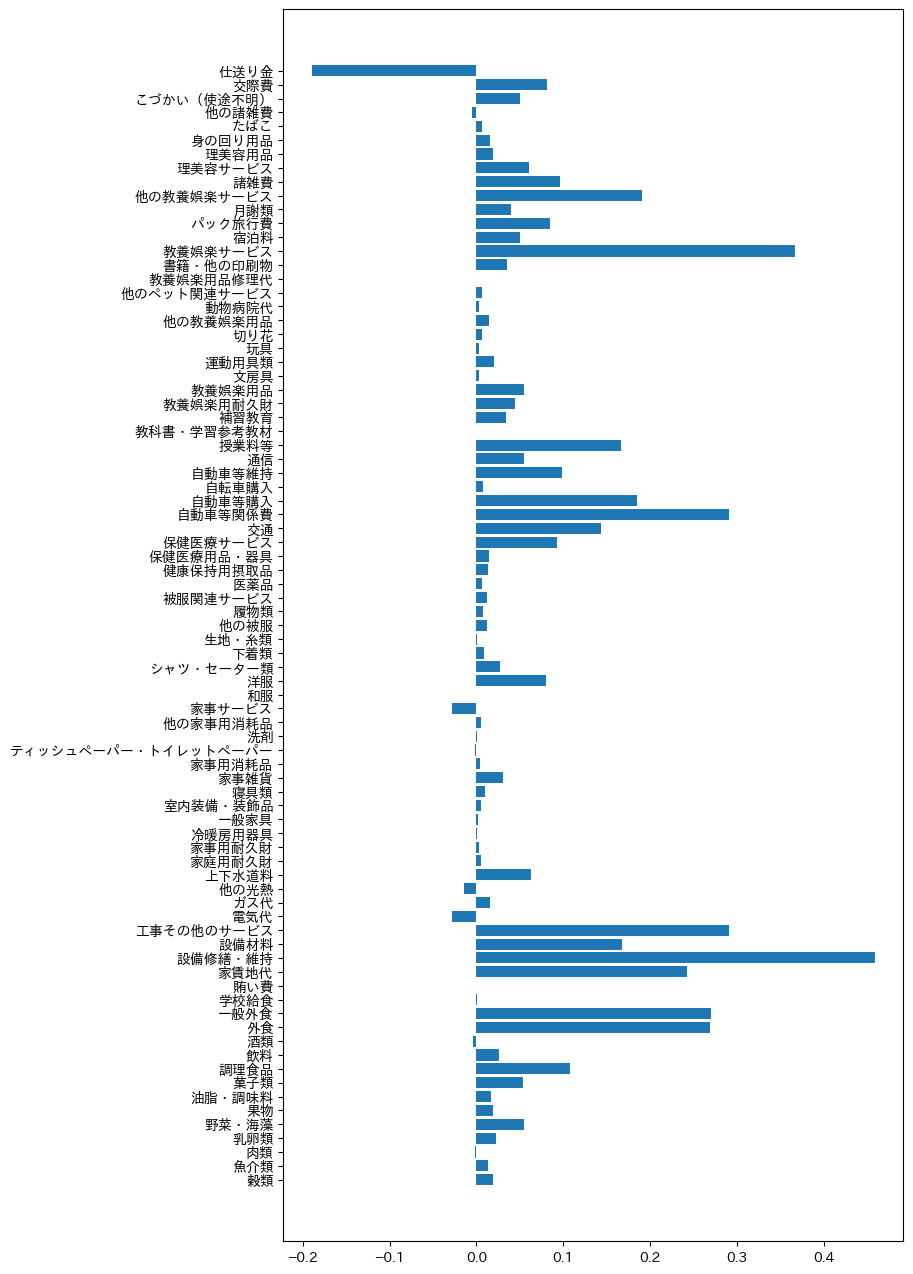

In [ ]:
plt.figure(figsize=(8,16))
plt.barh(list(dfpref.columns),Vp[:,1])

これを見ると、「教養娯楽サービス」と「設備修繕・維持」の重み係数が突出して高く、「仕送り」はマイナスに大きいことが分かります。このことから、例えば、<font color="blue">第2主成分は、「自宅周辺で生活(衣食住)が完結しているかどうかの指標」</font>という仮説が立つのではないでしょうか。

もし、興味と時間があったら、第３主成分以降も分析してみてください。